# Data understanding
Ziel dieses Notebooks ist, die potenziell wichtigen Informationen in Wikidata explorativ zu begutachten. Dazu wird der [Wikidata Query Service](https://query.wikidata.org/) verwendet.

Ausserdem soll herausgefunden werden, welche Strassen in Basel in Wikidata erfasst sind. Dies hat zwei Ziele:
1. Wie kann der Wikidata Query Service mittels Python angesprochen werden. Dies ist wichtig da später die Strassennamen mit den Einträgen in Wikidata abgeglichen werden sollen.
2. Sind bereits Strassen in Basel in Wikidata erfasst und besitzen die gegebenenfalls bereits eine Verlinkung zu dem namensgebenden Objekt. Dies könnte interessant sein, da die Informationen für eine Qualitätskontrolle des Abgleichprozesses genutzt werden könnten.

---
## Strassen mit Wikidata in Basel in OSM
Aus Wikidata können nur Objekte mittels geografischer Abfrage gefunden werden, welche über ein Statement [coordinate location](https://www.wikidata.org/wiki/Property:P625) verfügen. Da dies jedoch nicht sichergestellt ist, wird zuerst überprüft, ob allenfalls in OpenStreetMap bereits Strassen im Kanton Basel mit einem [Wikidata Key](https://wiki.openstreetmap.org/wiki/Key:wikidata) versehen sind.


In [1]:
import requests

#overpass_url = "http://overpass-api.de/api/interpreter"
overpass_url = "https://lz4.overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-2"="CH-BS"];
(
nwr["wikidata"]["highway"](area);
);
(._;>;);
out body;
"""

response = requests.get(overpass_url, data = overpass_query)
print(response)

<Response [200]>


In [2]:
data = response.json()

In [3]:
#print(data["elements"])

In [4]:
import pandas as pd
dfp = pd.DataFrame(data["elements"])

In [5]:
#!pip install osm2geojson

In [6]:
import osm2geojson

geojson = osm2geojson.json2geojson(data)

In [7]:
import geopandas as gpd
points = gpd.GeoDataFrame.from_features(geojson, crs="EPSG:4326")

In [8]:
points.head(2)

,geometry,type,id,tags,nodes
0,"LINESTRING (7.58169 47.56651, 7.58164 47.56659...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475..."
1,"LINESTRING (7.59802 47.53632, 7.59818 47.53632...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827..."


In [9]:
points2 = pd.json_normalize(points.to_dict('list'), ['tags'])
points2.head(2)

,highway,lanes,lit,maxspeed,name,oneway,sidewalk,surface,wikidata,name:etymology:wikidata,...,lanes:backward,lanes:forward,turn:lanes:backward,turn:lanes:forward,tunnel,cycleway:left:lane,access,foot,covered,cycleway:both:lane
0,tertiary,2,yes,50,Elsässerstrasse,no,both,asphalt,Q111632663,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,residential,NaN,NaN,NaN,Albert Schweitzer-Strasse,NaN,NaN,asphalt,Q27067517,Q49325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dfGeo = pd.concat([points, points2[["name", "wikidata"]]], axis = 1)
dfGeo.head(2)

,geometry,type,id,tags,nodes,name,wikidata
0,"LINESTRING (7.58169 47.56651, 7.58164 47.56659...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663
1,"LINESTRING (7.59802 47.53632, 7.59818 47.53632...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517


In [11]:
dfGeo = dfGeo.to_crs(epsg=3857)

In [12]:
dfGeo.head(2)

,geometry,type,id,tags,nodes,name,wikidata
0,"LINESTRING (843990.282 6035037.672, 843984.249...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663
1,"LINESTRING (845807.862 6030058.573, 845825.618...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517


In [13]:
print(f"Anzahl Strassen in Basel die in OSM mit einem wikidata versehen sind: {len(dfGeo.name.unique())}")

Anzahl Strassen in Basel die in OSM mit einem wikidata versehen sind: 18


Die Geometrien in einer Karte darstellen

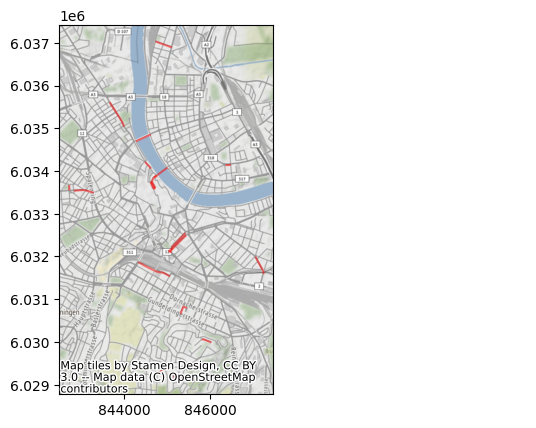

In [14]:
import contextily as cx
ax = dfGeo.plot(color="red", alpha=0.5)
cx.add_basemap(ax)

In [15]:
# Wird nur gebraucht sollte eine interaktive Karte angezeigt werden 
# !pip install folium matplotlib mapclassify

In [16]:
# Zeigt die interaktive Karte an
# dfGeo.explore(tooltip=["name", "wikidata"], width="70%", height="70%")

---
## Wikidata Informationen abfragen

### "instance of" der OSM-Strassen
Herausfinden, von welchen "Wikidata-Typ" (Wikidata-Property [instance of](https://www.wikidata.org/wiki/Property:P31)) die Elemente sind, welche in OSM mit dem wikidata-Tag versehen sind.  
Informationen von: https://people.wikimedia.org/~bearloga/notes/wdqs-python.html

In [17]:
#!pip install SPARQLWrapper

In [18]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

In [19]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

In [20]:
def queryWd(sparql, wdKey):
    #print(wdKey)
    query = """
    SELECT ?INR ?instance ?instanceLabel 
    WHERE 
    {
    wd:%s wdt:P31 ?instance.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "de" . }
    BIND(CONCAT("Q",STRAFTER(STR(?instance), "Q")) AS ?INR)
    }
    """ % (wdKey)
    #print(query)
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql
    

In [21]:
for x in dfGeo.index:
    wdKey = dfGeo['wikidata'][x]
    #print(wdKey)
    sparql = queryWd(sparql, wdKey)
    
    # Inner For-Loop to make sure a query will be repeated after a 429 occured
    for i in range(0,5):
        try:
            results = sparql.query()
            #print(results.info())
            break
        except HTTPError as e:
            print(f"{i} Anfragen ausgeführt")
            #Prüfen auf Statuscode 429 (Too many Requests)
            if e.status == 429:
                print(f'Statuscode 429 aufgetreten: Anfrage geht in {e.headers.get("retry-after")}sec weiter')
                sleep(int(e.headers.get("retry-after"))+2)
                continue
            else:
                raise
    
    result = results.convert()
    
    results_df = pd.json_normalize(result['results']['bindings'])
    #print(results_df[['instanceLabel.value']])
    dfGeo.at[x, "wdInstance"] = results_df['instanceLabel.value'][0]
    dfGeo.at[x, "wdInstanceKey"] = results_df['INR.value'][0]

In [22]:
dfGeo.head(2)

,geometry,type,id,tags,nodes,name,wikidata,wdInstance,wdInstanceKey
0,"LINESTRING (843990.282 6035037.672, 843984.249...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663,Innerortsstraße,Q79007
1,"LINESTRING (845807.862 6030058.573, 845825.618...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517,Innerortsstraße,Q79007


Prüfen, welchen Wikidatainstanzen für Strassen als "instence of" in Basel vergeben wurden:

In [23]:
dfGeo[["wdInstance", "wdInstanceKey"]].drop_duplicates()

,wdInstance,wdInstanceKey
0,Innerortsstraße,Q79007
3,Straßenbrücke,Q537127
10,Platz,Q174782
20,Bogenbrücke,Q158438


In [24]:
strInstKeys = dfGeo.wdInstanceKey.unique()

### Wikidata nach "named after" durchsuchen
Alle Strassen in Wikidata dieser gefunden Instanzen in Basel abfragen. Bei der Abfrage werden nur Objekte beachtet, die über eine Statement [named after](https://www.wikidata.org/wiki/Property:P138) verfügen

In [25]:
def queryWdStr(sparql, wdKey):
    #print(wdKey)
    query = """
    SELECT ?instanceLabel ?benanntTypLabel
    {   
      {
        SELECT ?instance (sample(?benanntTyp) AS ?benanntTyp)
               {
                 ?instance wdt:P31 wd:%s;
                           wdt:P131 wd:Q78;
                           wdt:P138 ?benannt.
                 ?benannt wdt:P31 ?benanntTyp.
               }
        GROUP BY ?instance
      }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "de,en". }
    }
    """ % (wdKey)
    #print(query)
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql

In [26]:
wdf = pd.DataFrame()

for wdKey in strInstKeys:
    #print(wdKey)
    sparql = queryWdStr(sparql, wdKey)
       
    # Inner For-Loop to make sure a query will be repeated after a 429 occured
    for i in range(0,5):
        try:
            results = sparql.query()
            #print(results.info())
            break
        except HTTPError as e:
            print(f"{i} Anfragen ausgeführt")
            #Prüfen auf Statuscode 429 (Too many Requests)
            if e.status == 429:
                print(f'Statuscode 429 aufgetreten: Anfrage geht in {e.headers.get("retry-after")}sec weiter')
                sleep(int(e.headers.get("retry-after"))+2)
                continue
            else:
                raise

    result = results.convert()
    
    results_df = pd.json_normalize(result['results']['bindings'])
    wdf = pd.concat([wdf, results_df])

In [27]:
wdf[["instanceLabel.value", "benanntTypLabel.value"]].head(2)

,instanceLabel.value,benanntTypLabel.value
0,Arbedostrasse,politische Gemeinde
1,Arlesheimerstrasse,politische Gemeinde


In [28]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 0
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   instanceLabel.xml:lang    20 non-null     object
 1   instanceLabel.type        20 non-null     object
 2   instanceLabel.value       20 non-null     object
 3   benanntTypLabel.xml:lang  20 non-null     object
 4   benanntTypLabel.type      20 non-null     object
 5   benanntTypLabel.value     20 non-null     object
dtypes: object(6)
memory usage: 1.1+ KB


In [29]:
print(f"Anzahl Strassen in Basel die in Wikidata mit einem Statement 'named after': {len(wdf.index)}")

Anzahl Strassen in Basel die in Wikidata mit einem Statement 'named after': 20


### Darstellung des Resultats
Die Typen, nach welchen Strassen in Wikipedia benannt sind, plus deren Anzahl in einer Tabelle und einem Diagramm ausgeben.

In [30]:
import matplotlib.pyplot as plt

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [31]:
pltdf = wdf.groupby("benanntTypLabel.value")["benanntTypLabel.value"].count()
#print(pltdf)

In [32]:
pltdf2 = pd.DataFrame({"typ":pltdf.index, "count":pltdf.values})
pltdf2.head(10)

,typ,count
0,Burg,1
1,Dorf,1
2,Familie,1
3,Gemeinde in Frankreich,1
4,Kirchengebäude,1
5,Mensch,5
6,Staatenbund,1
7,politische Gemeinde,9


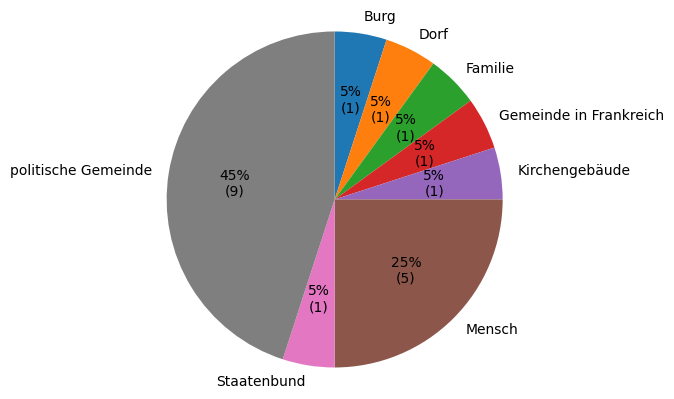

In [33]:
fig1, ax1 = plt.subplots()
ax1.pie(pltdf2["count"], labels=pltdf2["typ"], autopct=make_autopct(pltdf2["count"]), startangle=90, counterclock=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()